In [23]:
%matplotlib inline
import ast
import json
import urllib
import urllib2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cStringIO import StringIO


# note: this is python2 only code

We define a helper function <b>queryCartoDB</b> to wrap around the SQL API of CartoDB. We can simply pass in a public data source (in the form of 'https://{ACCOUNT}.cartodb.com/api/v2/sql', where ACCOUNT is the owner of the data) and a SQL statement for us to query the data in various formats including CSV, JSON, and GeoJSON. The result returned from this function is a file-like object, where we can pass to file readers such as Pandas' <b>read_csv()</b> or the JSON parser.

In our example, <b>source</b> is assigned a citibike data set available on the htv210 account.

We also assign <b>query1</b> and <b>query2</b> as the sample solution of homework 7.

In [24]:
def queryCartoDB(source, query, format='CSV'):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

source = 'https://fb55.cartodb.com/api/v2/sql'


We are just playing around with SQL statements in the next step. Note that, data can be retrieved in any format that we prefer.

In [25]:
query = '''
SELECT *
FROM citibike
LIMIT 10
'''

result = queryCartoDB(source, query, 'CSV')
df     = pd.read_csv(result)
df.head()

,cartodb_id,the_geom,the_geom_webmercator,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,976,NaN,NaN,393,2015-02-01 10:43:00+00,2015-02-01 10:50:00+00,504,1 Ave & E 15 St,40.732219,-73.981656,439,E 4 St & 2 Ave,40.726281,-73.989780,20967,Subscriber,1988,1
1,2920,NaN,NaN,464,2015-02-01 14:15:00+00,2015-02-01 14:23:00+00,434,9 Ave & W 18 St,40.743174,-74.003664,494,W 26 St & 8 Ave,40.747348,-73.997236,19083,Subscriber,1984,1
2,3157,NaN,NaN,600,2015-02-01 14:39:00+00,2015-02-01 14:49:00+00,305,E 58 St & 3 Ave,40.760958,-73.967245,527,E 33 St & 2 Ave,40.744023,-73.976056,17711,Subscriber,1980,2
3,5285,NaN,NaN,368,2015-02-01 18:08:00+00,2015-02-01 18:14:00+00,483,E 12 St & 3 Ave,40.732233,-73.988900,174,E 25 St & 1 Ave,40.738177,-73.977387,20576,Subscriber,1991,1
4,5901,NaN,NaN,203,2015-02-01 20:11:00+00,2015-02-01 20:14:00+00,236,St Marks Pl & 2 Ave,40.728419,-73.987140,445,E 10 St & Avenue A,40.727408,-73.981420,18362,Subscriber,1989,1


For the second query, where we would like visualize the output geometries, we use the Python's JSON module to parse the data and feed it to a GeoDataFrame. We can see the result in a plot

In [26]:
result = queryCartoDB(source, query2, 'GeoJSON')
data   = json.loads(result.read())
gdata  = gpd.GeoDataFrame.from_features(data['features'])

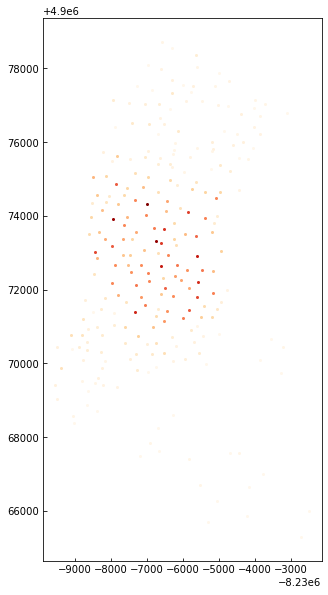

In [27]:
f, ax = plt.subplots(1, figsize=(5,10))
gdata.plot(column='trip_count', colormap='OrRd', alpha=1, axes=ax,  k=9)

To make the dots larger, we could create a buffer at each point (200 ft radius) and reassign the GeoDataFrame geometries.

In [28]:
dots   = gdata.set_geometry(gdata.geometry.buffer(100))

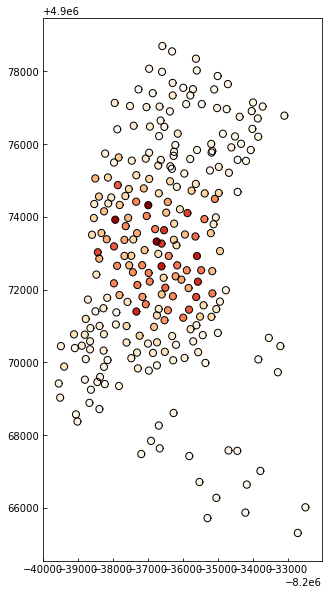

In [29]:
f, ax = plt.subplots(1, figsize=(5,10))
dots.plot(column='trip_count', colormap='OrRd', alpha=1, axes=ax, 
          k=9)